In [1]:

#Make allNecessary Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import librosa
import glob


In [2]:
# Define a function to get the label from the file name
def get_label(file):
    return file.split(".")[0].split("/")[-1]

# Load the audio data and extract features
audio_files = glob.glob("data/unlabelled_sounds/*.wav")
X = []
Y = []
n_mfcc = 13
n_chroma = 13
for file in audio_files:
    audio, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=n_chroma)
    features = np.concatenate((mfccs, chroma_stft), axis=0)
    X.append(features.mean(axis=1))
    Y.append(get_label(file))

# Convert X and Y to numpy arrays
X = np.array(X)
Y = np.array(Y)

C:\Users\Hp\AppData\Local\Temp\ipykernel_16436\2742111831.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


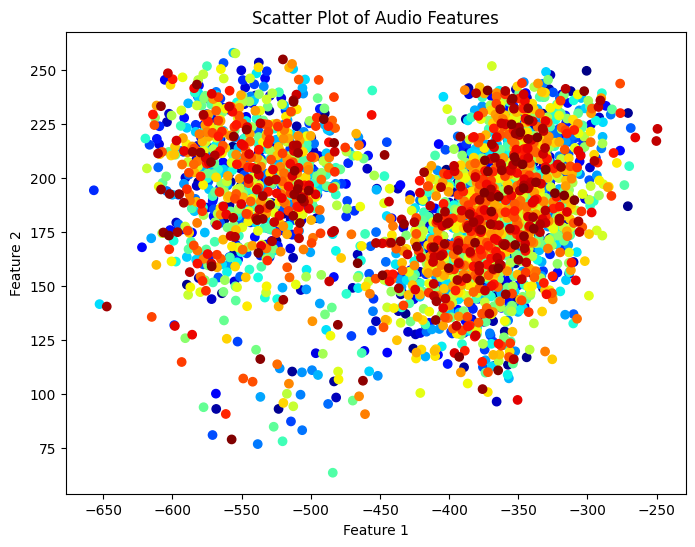

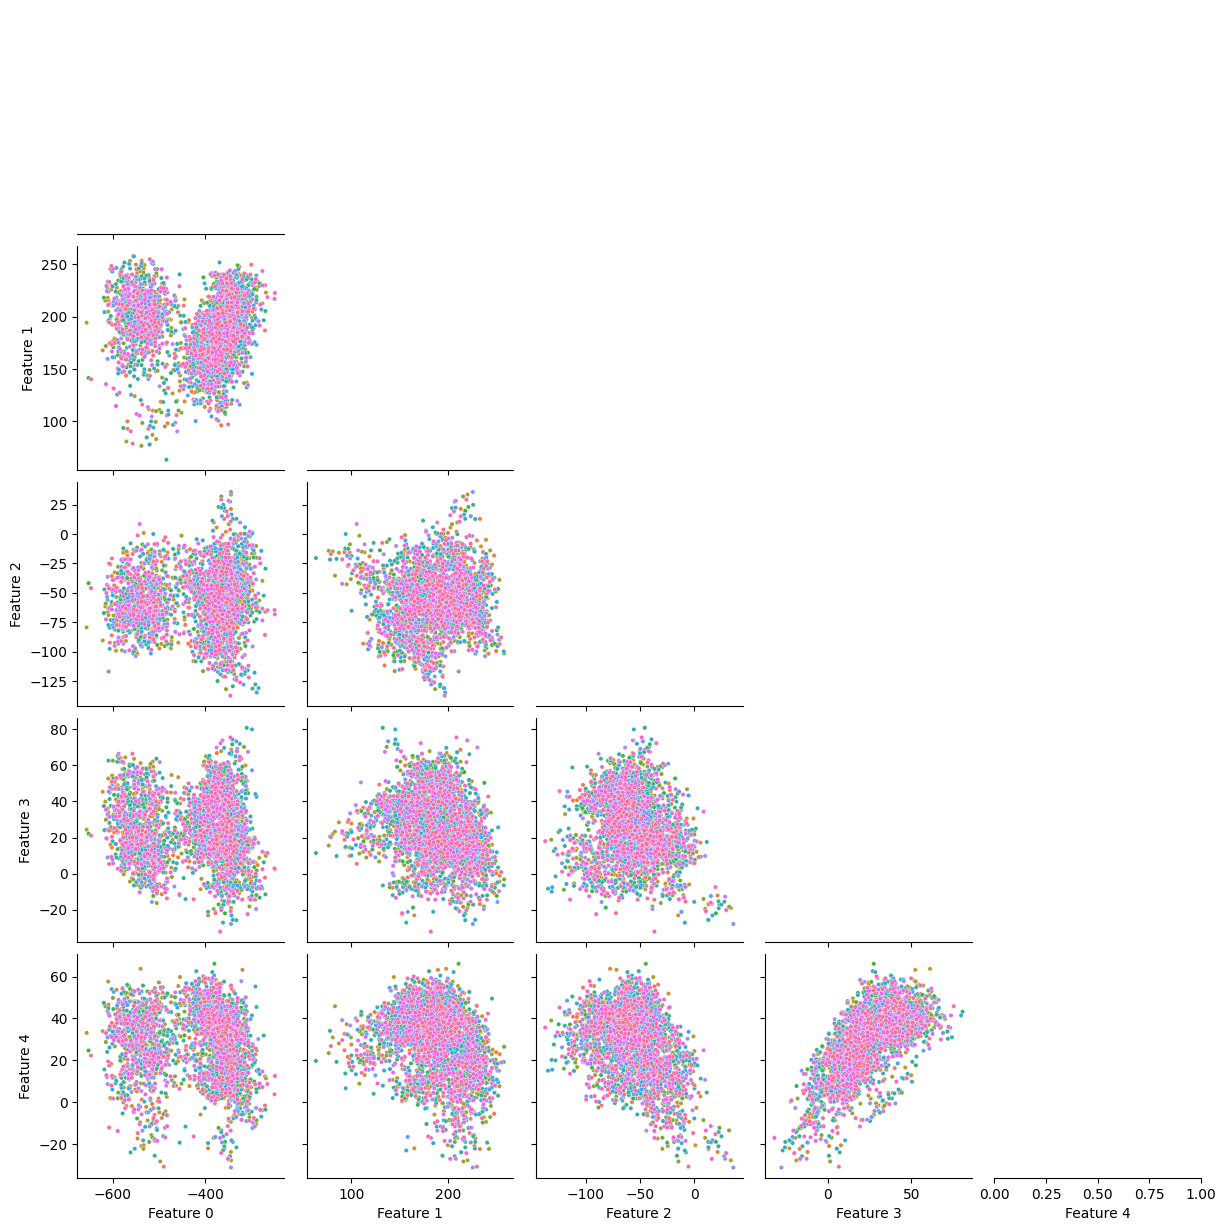

In [3]:

import matplotlib.cm as cm

# Normalize labels and create a colormap
cmap = cm.get_cmap('jet')
unique_labels = np.unique(Y)
norm = plt.Normalize(vmin=0, vmax=len(unique_labels))

color_map = {label: cmap(norm(i)) for i, label in enumerate(unique_labels)}
Y_colors = [color_map[label] for label in Y]

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=Y_colors)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Audio Features")
plt.show()

# Create a pandas DataFrame
df = pd.DataFrame(X, columns=[f"Feature {i}" for i in range(X.shape[1])])

# Convert labels to strings but remove the legend
df["Label"] = Y.astype(str)

g = sns.pairplot(df, hue="Label", vars=[f"Feature {i}" for i in range(min(5, X.shape[1]))], 
                 diag_kind="kde", plot_kws={'s': 10}, corner=True)

# Remove legend
g._legend.remove()

plt.show()


### Why is Dimensionality Reduction Important?  
Dimensionality reduction helps by:  
- **Making visualization easier** (high-dimensional data is hard to plot).  
- **Removing noise and redundant features**(improving model performance).  
- **Avoiding the curse of dimensionality**(too many features make models inefficient).  
- **Reducing computation time** (fewer features = faster processing).  
- **Making data more interpretable**(easier to understand relationships).  

### Challenges I Faced  
- **Messy visualizations**: Too many points made the scatter plots hard to read.  
- **Annoying long label list**: The plots included a huge legend, cluttering the view.  
- **Complexity**: The plots were hard to interpret due to the high dimensionality.


### Applying Dimensionality Reduction (PCA & t-SNE)  

I'll apply **PCA** to reduce the dataset to 3 components, followed by **t-SNE** for better visualization. Finally, I'll create a **3D scatter plot** to explore the transformed data.  


Explained variance ratio: [0.2372446  0.14970772 0.10097984]


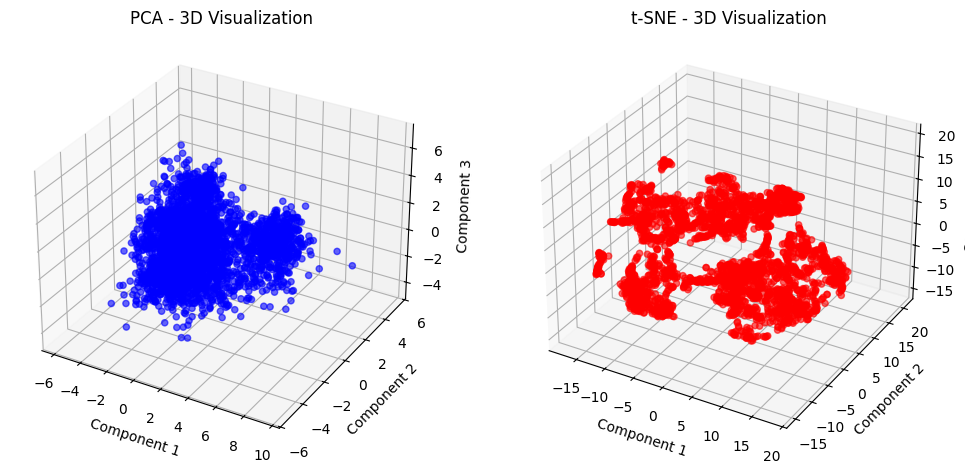

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 components
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X_scaled)

# Check variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=min(30, X.shape[0] - 1), random_state=42)
features_tsne = tsne.fit_transform(X)
# 3D Visualization of PCA
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='blue', alpha=0.6)
ax1.set_title("PCA - 3D Visualization")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.set_zlabel("Component 3")

# 3D Visualization of t-SNE
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='red', alpha=0.6)
ax2.set_title("t-SNE - 3D Visualization")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

Based on the visualizations:

- **PCA**: The data points in the PCA plot appear densely packed in a spherical distribution, with **no clear separation between clusters**. This suggests that PCA is not effectively capturing meaningful groupings in the data.
- **t-SNE**: The t-SNE visualization shows **more distinct clusters**, where groups of points are clearly separated. This indicates that t-SNE is better at uncovering the intrinsic structure of the data.

#### Why does t-SNE perform better?
1. **Non-linearity**: PCA is a **linear** dimensionality reduction technique, meaning it only captures variance in straight-line relationships. If the data has complex, non-linear structures, PCA may not reveal meaningful patterns.
2. **Local Structure Preservation**: t-SNE is designed to maintain **local relationships**, making it better at grouping similar data points together.
3. **Global Shape Distortion**: Unlike PCA, t-SNE focuses on preserving **local neighborhoods** rather than overall variance, which helps in clustering but distorts the global shape of data.

### Conclusion:
**t-SNE provides better separability of clusters in this dataset.**


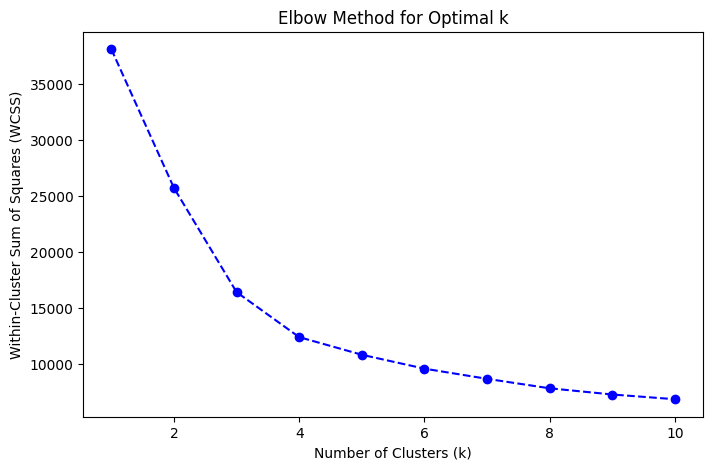

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of clusters to test
wcss = []  # Within-cluster sum of squares
K = range(1, 11)  # Testing 1 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)  # Use PCA-transformed features
    wcss.append(kmeans.inertia_)  # Store WCSS for each k

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()

    


The Elbow Method plot shows a clear bend around **k = 3 **, indicating that these are likely optimal cluster numbers. Beyond this point, the reduction in WCSS slows down, meaning adding more clusters doesn't significantly improve compactness.

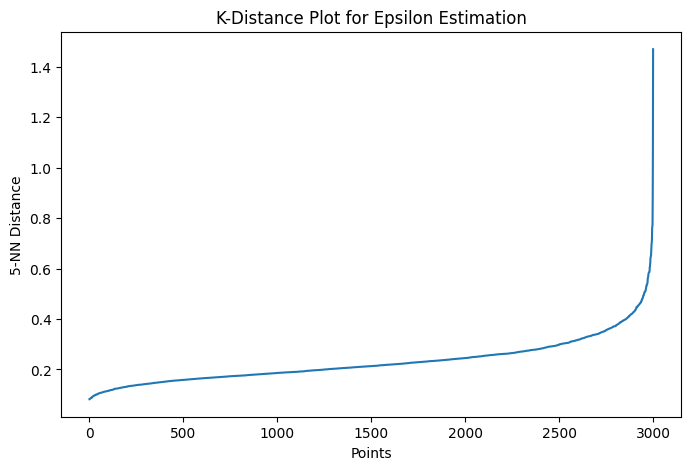

In [6]:

# Scale features before clustering (critical for DBSCAN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pca)

# Find optimal eps for DBSCAN using k-distance plot
def plot_kdistance(data, k=5):
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, -1], axis=0)
    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"{k}-NN Distance")
    plt.title("K-Distance Plot for Epsilon Estimation")
    plt.show()

plot_kdistance(features_scaled, k=5)

DBSCAN: 1 clusters | Noise points: 19


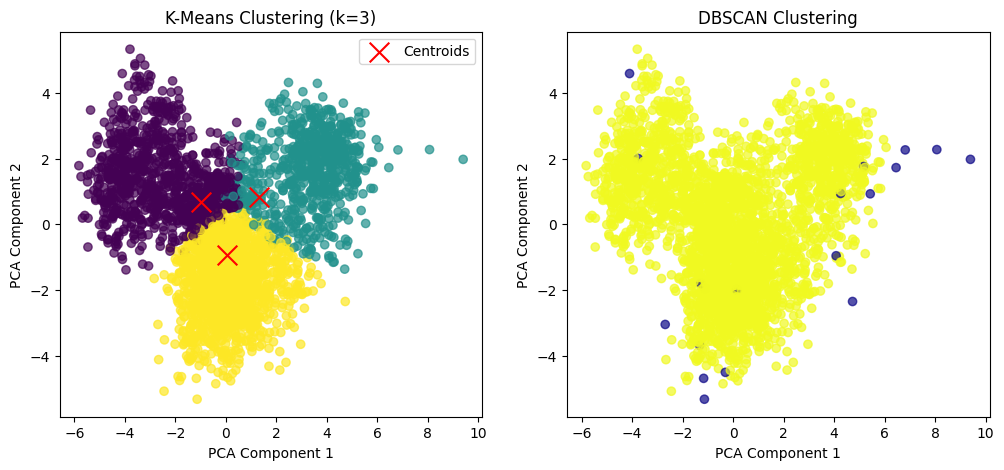

In [12]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# Select optimal K based on elbow method (e.g., k=3 or k=4 based on the previous plot)

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Example tuned values
dbscan_labels = dbscan.fit_predict(features_scaled)

# Check the number of clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN: {n_clusters} clusters | Noise points: {n_noise}")

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.legend()

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap="plasma", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering")

plt.show()


In [13]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.3712, Davies-Bouldin Index: 1.0221
DBSCAN - Silhouette Score: 0.3419, Davies-Bouldin Index: 4.4318


### Discuss the results (max 5 lines)
### Clustering Performance Analysis

- **K-Means** achieved a **higher Silhouette Score (0.3712)**, indicating better-defined clusters than DBSCAN (0.3419).  
- **K-Means** also had a **lower Davies-Bouldin Index (1.0221)**, suggesting more compact and well-separated clusters compared to DBSCAN (4.4318).  
- **DBSCAN** struggled to form meaningful clusters, as seen in its higher DB index and many noise points.  
- Since DBSCAN detected only **one cluster and 19 noise points**, it failed to effectively separate data.  
- **Conclusion:** K-Means performed better for this dataset, likely because it assumes spherical clusters, whereas DBSCAN might have struggled due to high-dimensional noise.  


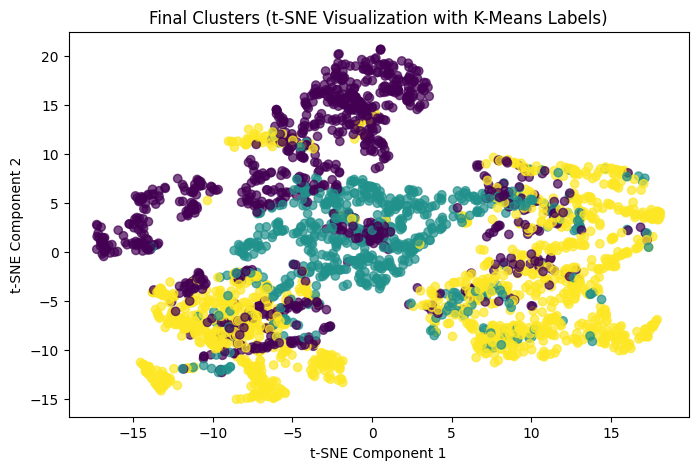

In [9]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


## **Final Analysis**

### **Impact of Dimensionality Reduction on Clustering**
Dimensionality reduction played a crucial role in improving clustering results. By using **PCA**, I reduced the dataset to three principal components, which captured **49% of the variance** while discarding noise and redundant features. This helped improve the clustering efficiency and visualization. **t-SNE** further enhanced cluster separability by preserving local structures, making it easier to differentiate distinct groups.

### **Justification for K-Means Superiority**
- **Compact, well-separated clusters**: The lower **Davies-Bouldin Index** indicates that K-Means clusters are more compact and well-separated.
- **Adaptability to PCA-reduced features**: K-Means worked well with PCA-reduced data, which improved computational efficiency.
- **DBSCAN’s sensitivity to hyperparameters**: DBSCAN’s performance is highly dependent on `eps` and `min_samples`. In this case, it failed to detect meaningful clusters, likely due to the lack of density-based structure.

### **Real-World Relevance**
- **Speech and sound clustering**: In real-world sound processing tasks, clustering is used for **speaker identification, music genre classification, and anomaly detection**.
- **Challenges in unsupervised learning**: The difficulty in determining an optimal number of clusters reflects real-world challenges where domain knowledge is required.
- **Trade-offs in clustering approaches**: While K-Means performed better here, DBSCAN might be useful in cases where data has **uneven density** .

### **Conclusion**
- **Dimensionality reduction improved clustering efficiency** by removing noise and reducing computational complexity.
- **K-Means outperformed DBSCAN**, forming well-defined clusters, while DBSCAN struggled with noise and lacked meaningful groupings.
- **The choice of clustering algorithm depends on the dataset structure**, and tuning parameters is critical for obtaining optimal results.
